# 2. Large-scale learning for FPM

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import os, sys
import argparse
import time
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

import time

# MELD toolbox
import meld.recon as recon
from meld.recon import UnrolledNetwork
from meld.util import getAbs,getPhase

# import local experiment files
sys.path.append('../')
import dataloader
import visualizer
import model

# Setup device
device_no = 1
torch.cuda.set_device(device_no)
device = torch.device("cuda:"+str(device_no) if torch.cuda.is_available() else "cpu")

In [3]:
N = 200
torch.cuda.empty_cache()
startmem = torch.cuda.memory_cached(device)
X = torch.from_numpy(np.random.randn(N,N).astype(np.float32))
X = X.to(device)
endmem = torch.cuda.memory_cached(device)
mem3 = (endmem - startmem) / 1024**2
print('Memory per checkpoint: {0:d}MB'.format(int(mem3)))

memlimit = 10000

Memory per checkpoint: 282MB


In [4]:
# print(np.sum(X.shape)/mem3)
voxels = X.shape[0] * X.shape[1] * X.shape[2]
print(voxels)
print(voxels/(mem3*1024**2))

73500000
0.24856405055269282


In [5]:
path = '/home/kellman/Workspace/PYTHON/Design_FPM_pytorch/datasets_train_ode_test/train_amp_exp_10000_293leds.mat' 
dataset = dataloader.dataloader(path, 20, 5, device)
metadata = dataset.getMetadata()
metadata['Np'] = dataset[0][0].shape[2:]
metadata['num_bf'] = 1
metadata['num_df'] = 5
metadata['num_unrolls'] = 100
metadata['alpha'] = 0.2
metadata['T'] = 4
print('Number of elements in dataset: {0:d}'.format(len(dataset)))
# input_data, output_data = dataset[3]
# print(input_data.shape)
# print(output_data.shape)


Number of elements in dataset: 10


In [11]:
def setup_run(num_unrolls, memlimit, meldFlag=False, setupFlag=False, cpList=None):
#     metadata['num_unrolls'] = num_unrolls
#     network = model.model(metadata, device=device)
    torch.cuda.empty_cache()
    startmem = torch.cuda.memory_cached(device)
    input_data, output_data = dataset[0]
    input_data = input_data.to(device)
    endmem = torch.cuda.memory_cached(device)
    mem3 = (endmem - startmem) / 1024**2
    print('Memory per checkpoint: {0:d}MB'.format(int(mem3)))
    
#     xtest = network.initialize(input_data[:1,...], device=device)
#     trainable_network = UnrolledNetwork(network.network, 
#                                         xtest, 
#                                         memlimit=memlimit, 
#                                         setupFlag = setupFlag,
#                                         device=device)


# #     if cpList is not None:
# #         trainable_network.cpList = cpList
# #     else:
# #         trainable_network.cpList = [-1]
# #     if trainable_network.meldFlag is False:
# #         trainable_network.cpList = [-1]
#     return network, trainable_network

In [12]:
# network, trainable_network = setup_run(100, memlimit=10000, setupFlag=True)
setup_run(100, memlimit=10000, setupFlag=True)

Memory per checkpoint: 58MB


In [8]:
# setup data
input_data, output_data = dataset[0]
x0 = network.initialize(input_data.to(device), device=device)
xN_tmp, loss_tmp, _, _ = trainable_network.forward(x0, output_data.to(device))


torch.Size([101, 101, 2])


<IPython.core.display.Javascript object>


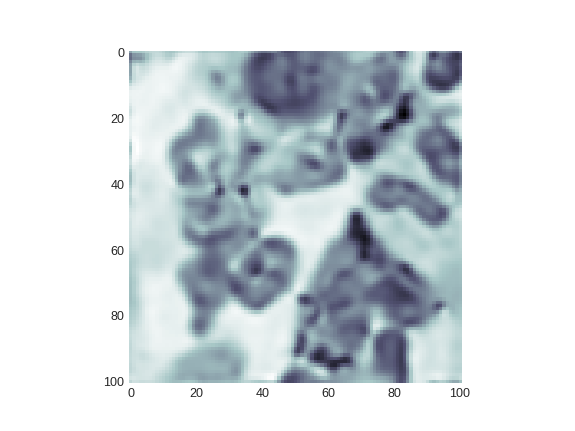

In [9]:
print(xN_tmp.shape)
x_meld_abs_np = getAbs(xN_tmp.detach()).cpu().numpy()
view = lambda x : x[::-1]
plt.figure()
plt.imshow(view(x_meld_abs_np),cmap='bone')